## Super Resoultion - Deep Learning - Magnetic Data

In [3]:
# Standard library
from typing import Dict, Optional, Union

# Data processing
import numpy as np
import xarray as xr
from scipy import interpolate, ndimage
from skimage import color
from sklearn.preprocessing import StandardScaler

# Data storage
import rioxarray
import zarr
from rasterio import enums
from rasterio.enums import Resampling

# Data visualization
import matplotlib.pyplot as plt

In [4]:
import dask
import dask.array as da
from dask import delayed
from dask.distributed import Client

print(f"Dask version: {dask.__version__}")

Dask version: 2024.9.1


This dask client should be modified for your hardward. This seemed to work pretty well, but like all things dask could be optimized further I am sure. 

In [5]:
# Configuration for M2 MacBook Pro (32GB RAM)
client = Client(
    n_workers=6,                   # M2 has 8 performance cores + 4 efficiency cores
    threads_per_worker=2,          # 2 threads per worker for balanced performance
    memory_limit='4GB',            # ~24GB total for Dask (leaving 8GB for system)
    lifetime='4h',                 # Auto-shutdown after 4 hour of inactivity
    dashboard_address=':8787'      # Enable dashboard for monitoring
)

/Users/tmartin/miniforge3/envs/py312/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53783 instead
  warnings.warn(


In [6]:
# This will show the dashboard link and usually auto-opens in your browser
client.dashboard_link

'http://127.0.0.1:53783/status'

hello

In [7]:
wy_state = 'WY_statemag_OFR00-0198.tif/WY_statemag_OFR00-0198.tif'
new_survey = 'WY_statemag_OFR00-0198.tif/TotalMag_AirborneMagneticSurveyMedicineBowWY2023.tif'

In [8]:
class RasterProcessor:
    def __init__(self, client=None, chunk_size: int = 1024):
        """
        Initialize the RasterProcessor.
        
        Args:
            client: Dask client for distributed computing
            chunk_size: Default chunk size for Dask arrays
        """
        self.client = client
        self.chunk_size = chunk_size

    def process_raster(
        self,
        file_path: str,
        drop_single_value_bands: bool = True,
        verbose: bool = False
    ) -> xr.Dataset:
        """
        Process a GeoTIFF file using Dask for efficient chunked processing.
        
        Args:
            file_path: Path to the GeoTIFF file
            drop_single_value_bands: Whether to drop bands with single unique value
            verbose: Whether to print processing information
        """
        if verbose:
            print(f"Processing raster: {file_path}")
            
        # Read the raster with chunking
        raster = rioxarray.open_rasterio(
            file_path,
            chunks={
                'band': 1,
                'x': self.chunk_size,
                'y': self.chunk_size
            }
        )
        
        if verbose:
            print(f"\nSpatial Information:")
            print(f"CRS: {raster.rio.crs}")
            resolution = raster.rio.resolution()
            print(f"Resolution: {resolution[0]:.2f} x {resolution[1]:.2f} units")
            bounds = raster.rio.bounds()
            print(f"Bounds: {bounds}")
            print(f"\nRaster Information:")
            print(f"Original shape: {raster.shape}")
        
        # Convert 255 to NaN using Dask
        raster = raster.where(raster != 255)
        
        # Drop single value bands if requested
        if drop_single_value_bands:
            bands_to_keep = []
            for i in range(raster.shape[0]):
                band = raster[i]
                # Compute unique values excluding NaN
                unique_vals = da.unique(band.data).compute()
                unique_vals = unique_vals[~np.isnan(unique_vals)]
                
                if len(unique_vals) > 1:
                    bands_to_keep.append(i)
                elif verbose:
                    if len(unique_vals) == 0:
                        print(f"Dropping band {i} (all NaN values)")
                    else:
                        print(f"Dropping band {i} (single value: {unique_vals[0]})")
            
            if not bands_to_keep:
                raise ValueError("No valid bands remaining after filtering")
                
            raster = raster[bands_to_keep]
            
            if verbose:
                print(f"Kept bands: {bands_to_keep}")
        
        # Convert to dataset
        ds = xr.Dataset()
        
        # Determine band names
        if raster.shape[0] == 3:
            band_names = ['r', 'g', 'b']
        else:
            band_names = [f'band_{i+1}' for i in range(raster.shape[0])]
            
        # Add bands to dataset
        for i, name in enumerate(band_names):
            ds[name] = raster[i]
            
        # Preserve spatial information
        ds.rio.write_crs(raster.rio.crs, inplace=True)
        ds.rio.write_transform(raster.rio.transform(), inplace=True)
            
        if verbose:
            print(f"Final dataset variables: {list(ds.data_vars.keys())}")
            
        return ds

    def mask_raster_area(
        self,
        raster: Union[xr.Dataset, xr.DataArray],
        mask: bool = False,
        x_min: float = None,
        x_max: float = None,
        y_min: float = None,
        y_max: float = None,
        verbose: bool = False
    ) -> xr.Dataset:
        """
        Mask (set to NaN) a specific area of the raster using spatial coordinates.
        
        Args:
            raster: Input raster (Dataset or DataArray)
            mask: Whether to apply masking
            x_min, x_max, y_min, y_max: Spatial coordinates for masking
            verbose: Whether to print masking information
        """
        if not mask:
            return raster
            
        if verbose:
            print("\nApplying spatial mask:")
            print(f"Bounds: x=[{x_min}, {x_max}], y=[{y_min}, {y_max}]")
        
        # Convert DataArray to Dataset if necessary
        if isinstance(raster, xr.DataArray):
            ds = raster.to_dataset(dim='band')
        else:
            ds = raster
            
        # Create mask based on coordinates
        mask = (
            (ds.x >= x_min) &
            (ds.x <= x_max) &
            (ds.y >= y_min) &
            (ds.y <= y_max)
        )
        
        # Apply mask to each variable
        masked_ds = xr.Dataset()
        for var_name, da in ds.data_vars.items():
            masked_ds[var_name] = da.where(~mask)
            
        # Preserve spatial information
        masked_ds.rio.write_crs(ds.rio.crs, inplace=True)
        masked_ds.rio.write_transform(ds.rio.transform(), inplace=True)
        
        if verbose:
            # Calculate masked percentage using first band
            first_var = list(masked_ds.data_vars.keys())[0]
            first_band = masked_ds[first_var]
            total_pixels = np.prod(first_band.shape)
            masked_pixels = np.isnan(first_band.data).sum().compute()
            pct_masked = (masked_pixels / total_pixels) * 100
            print(f"Masked {pct_masked:.2f}% of pixels")
            
        return masked_ds

    def compute_result(
        self,
        result: Union[xr.Dataset, xr.DataArray],
        persist: bool = False
    ) -> xr.Dataset:
        """
        Compute the final result efficiently using Dask.
        
        Args:
            result: Dataset or DataArray to compute
            persist: Whether to persist result in distributed memory
        """
        try:
            if persist and self.client:
                computed = result.persist(scheduler=self.client)
            else:
                computed = result.compute()
            
            # Convert DataArray to Dataset if necessary
            if isinstance(computed, xr.DataArray):
                if 'band' in computed.coords and len(computed.band) == 3:
                    ds = xr.Dataset({
                        'r': computed.sel(band='r'),
                        'g': computed.sel(band='g'),
                        'b': computed.sel(band='b')
                    })
                else:
                    ds = computed.to_dataset(dim='band')
                computed = ds
                
            return computed
            
        except Exception as e:
            print(f"Error computing result: {str(e)}")
            raise

In [9]:
# Initialize processor
processor = RasterProcessor(client=client)

# Process raster with interpolation parameters
result = processor.process_raster(
    file_path=wy_state,         
    verbose=True
)

# Compute and persist the result (this part stays the same)
raster1 = processor.compute_result(result, persist=True)
raster1

Processing raster: WY_statemag_OFR00-0198.tif/WY_statemag_OFR00-0198.tif

Spatial Information:
CRS: EPSG:26913
Resolution: 213.37 x -213.37 units
Bounds: (-19608.0, 4525836.0, 610480.0829760002, 5022779.835167999)

Raster Information:
Original shape: (3, 2329, 2953)
Kept bands: [0, 1, 2]
Final dataset variables: ['r', 'g', 'b']


<xarray.Dataset> Size: 83MB
Dimensions:      (x: 2953, y: 2329)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 24kB -1.95e+04 -1.929e+04 ... 6.102e+05 6.104e+05
  * y            (y) float64 19kB 5.023e+06 5.022e+06 ... 4.526e+06 4.526e+06
    spatial_ref  int64 8B 0
Data variables:
    r            (y, x) float32 28MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    g            (y, x) float32 28MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    b            (y, x) float32 28MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

In [10]:
# Initialize processor with the Dask client
processor = RasterProcessor(client=client)

# Process raster with automatic band dropping
result = processor.process_raster(
    file_path=new_survey,
    drop_single_value_bands=True,  # Set to False to keep all bands
    verbose=True
)

# Apply masking if needed
masked_result = processor.mask_raster_area(
    raster=result,
    mask=True,
    x_min=420000,
    x_max=428000,
    y_min=4560000,
    y_max=4610000,
    verbose=True
)

# Compute the final results
raster2 = processor.compute_result(masked_result, persist=True)
raster2

Processing raster: WY_statemag_OFR00-0198.tif/TotalMag_AirborneMagneticSurveyMedicineBowWY2023.tif

Spatial Information:
CRS: EPSG:32613
Resolution: 50.00 x -50.00 units
Bounds: (352146.0298581251, 4537756.482993433, 429646.0298581251, 4613806.482993433)

Raster Information:
Original shape: (4, 1521, 1550)
Dropping band 3 (all NaN values)
Kept bands: [0, 1, 2]
Final dataset variables: ['r', 'g', 'b']

Applying spatial mask:
Bounds: x=[420000, 428000], y=[4560000, 4610000]
Masked 53.49% of pixels


<xarray.Dataset> Size: 28MB
Dimensions:      (x: 1550, y: 1521)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 12kB 3.522e+05 3.522e+05 ... 4.296e+05 4.296e+05
  * y            (y) float64 12kB 4.614e+06 4.614e+06 ... 4.538e+06 4.538e+06
    spatial_ref  int64 8B 0
Data variables:
    r            (y, x) float32 9MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    g            (y, x) float32 9MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    b            (y, x) float32 9MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

## Greyscale

In [11]:
def enhanced_fill_holes(data, kernel_size=5, n_passes=2):
    """
    Enhanced hole filling for larger gaps while maintaining performance.
    
    Parameters:
    data (dask.array): Input data array
    kernel_size (int): Size of the kernel for neighborhood operations
    n_passes (int): Number of filling passes
    
    Returns:
    dask.array: Data with holes filled
    """
    def fill_chunk(chunk):
        # Ensure we're working with float64
        chunk = np.asarray(chunk, dtype=np.float64)
        result = chunk.copy()
        
        # Create kernels of different sizes for progressive filling
        kernels = [
            np.ones((size, size), dtype=np.float64) 
            for size in range(kernel_size, max(3, kernel_size - 2), -2)
        ]
        
        # Multiple passes with different kernel sizes
        for _ in range(n_passes):
            for kernel in kernels:
                mask = np.isnan(result)
                if not np.any(mask):
                    break
                
                # Compute weighted average of neighbors
                sum_neighbors = ndimage.convolve(
                    np.where(mask, 0, result),
                    kernel,
                    mode='constant',
                    cval=np.nan
                )
                
                count_neighbors = ndimage.convolve(
                    (~mask).astype(np.float64),
                    kernel,
                    mode='constant',
                    cval=0
                )
                
                # Fill holes where we have enough neighbors
                valid_fill = (count_neighbors > kernel.sum() * 0.2) & mask
                if np.any(valid_fill):
                    result[valid_fill] = sum_neighbors[valid_fill] / count_neighbors[valid_fill]
        
        return result
    
    return data.map_blocks(fill_chunk, dtype=np.float64)

def rgb_to_grayscale(raster_dataset, chunk_size=1024, kernel_size=7, n_passes=2):
    """
    Convert RGB xarray Dataset to grayscale with enhanced hole filling.
    
    Parameters:
    raster_dataset (xarray.Dataset): Input RGB raster data with r, g, b variables
    chunk_size (int): Size of Dask chunks
    kernel_size (int): Maximum size of kernel for hole filling
    n_passes (int): Number of filling passes
    
    Returns:
    xarray.Dataset: Dataset containing grayscale DataArray with preserved CRS
    """
    # Basic input validation
    required_vars = ['r', 'g', 'b']
    if not all(var in raster_dataset for var in required_vars):
        raise ValueError(f"Input Dataset must have {required_vars} variables")
    
    # Ensure CRS exists
    if not raster_dataset.rio.crs:
        raise ValueError("Input Dataset must have a defined CRS")
    
    # Convert to float64 explicitly
    chunked_dataset = raster_dataset.astype(np.float64).chunk({'y': chunk_size, 'x': chunk_size})
    
    # Simple weighted sum for grayscale
    grayscale_data = (
        0.2989 * chunked_dataset['r'].data.astype(np.float64) +
        0.5870 * chunked_dataset['g'].data.astype(np.float64) +
        0.1140 * chunked_dataset['b'].data.astype(np.float64)
    )
    
    # Enhanced hole filling
    grayscale_data = enhanced_fill_holes(
        grayscale_data, 
        kernel_size=kernel_size,
        n_passes=n_passes
    )
    
    # Create output dataset
    grayscale_da = xr.DataArray(
        grayscale_data,
        dims=['y', 'x'],
        coords={'y': raster_dataset.y, 'x': raster_dataset.x},
        name='grayscale'
    )
    
    output_dataset = xr.Dataset({'grayscale': grayscale_da})
    output_dataset.rio.write_crs(raster_dataset.rio.crs, inplace=True)
    
    return output_dataset

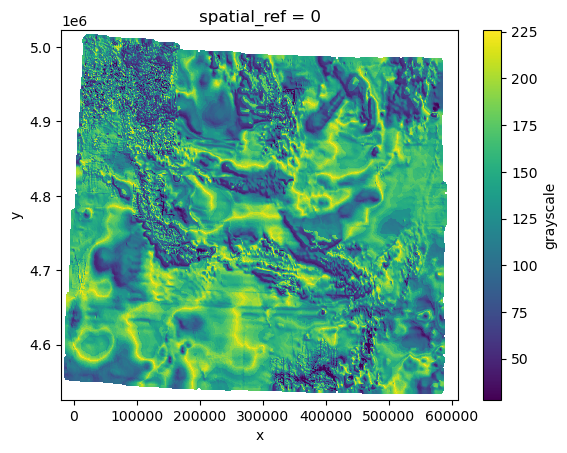

In [12]:
# Or with explicit nodata handling
ds1 = rgb_to_grayscale(raster1,
                       kernel_size=15,    
                       n_passes=3)

ds1.grayscale.plot()

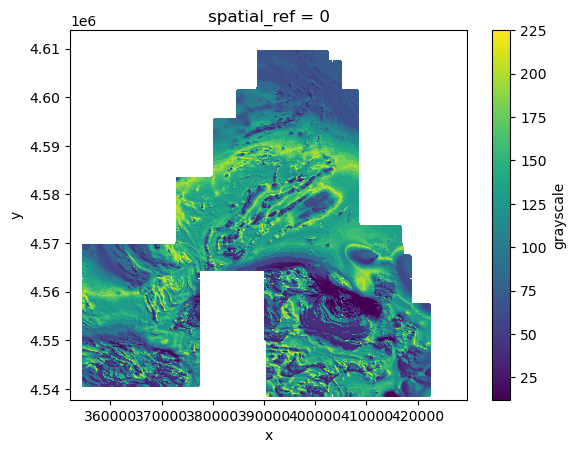

In [13]:
ds2 = rgb_to_grayscale(raster2,
                       kernel_size=5,    
                       n_passes=7)

ds2.grayscale.plot()

## Upscale

In [14]:
# Set the new resolution
new_resolution = (40.0, -40.0)

In [15]:
def reproject_dataset(
    dataset: xr.Dataset,
    target_crs: str,
    resolution: Optional[Union[float, tuple[float, float]]] = None,
    resampling_method: Resampling = Resampling.bilinear,
    verbose: bool = True
) -> xr.Dataset:
    """
    Reproject an xarray Dataset to a new CRS and optional resolution.
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        Input dataset with rio accessor
    target_crs : str
        Target coordinate reference system (e.g., 'EPSG:32613')
    resolution : float or tuple of float, optional
        Target resolution in units of target CRS. If float, same resolution
        will be used for both x and y. If tuple, (x_res, y_res).
        For y_res, a negative value indicates north-up orientation:
        - (40, -40) means 40m resolution with north at top
        - (40, 40) means 40m resolution with south at top
    resampling_method : rasterio.enums.Resampling, optional
        Resampling algorithm to use. Default is bilinear.
    verbose : bool, optional
        If True, print resolution and dimension information. Default is True.
    
    Returns:
    --------
    xarray.Dataset
        Reprojected dataset
    
    Examples:
    --------
    >>> # Reproject to UTM Zone 13N with 40m resolution, north-up
    >>> reprojected = reproject_dataset(
    ...     dataset=ds,
    ...     target_crs='EPSG:32613',
    ...     resolution=(40, -40)
    ... )
    """
    if verbose:
        print(f"Original resolution: {dataset.rio.resolution()}")
        print(f"Original dimensions: {dataset.rio.shape}")
        print(f"Original CRS: {dataset.rio.crs}")
    
    # Reproject the dataset
    reprojected = dataset.rio.reproject(
        dst_crs=target_crs,
        resolution=resolution,
        resampling=resampling_method
    )
    
    if verbose:
        print("\nAfter reprojection:")
        print(f"New resolution: {reprojected.rio.resolution()}")
        print(f"New dimensions: {reprojected.rio.shape}")
        print(f"New CRS: {reprojected.rio.crs}")
    
    return reprojected

In [16]:
raster1_40m = reproject_dataset(ds1, target_crs='EPSG:32613', resolution=new_resolution)

Original resolution: (213.37219200000004, -213.37219200000013)
Original dimensions: (2329, 2953)
Original CRS: EPSG:26913

After reprojection:
New resolution: (40.0, -40.0)
New dimensions: (12424, 15753)
New CRS: EPSG:32613


In [17]:
raster2_40m = reproject_dataset(ds2, target_crs='EPSG:32613', resolution=new_resolution)

Original resolution: (50.0, -50.0)
Original dimensions: (1521, 1550)
Original CRS: EPSG:32613

After reprojection:
New resolution: (40.0, -40.0)
New dimensions: (1902, 1938)
New CRS: EPSG:32613


## plots

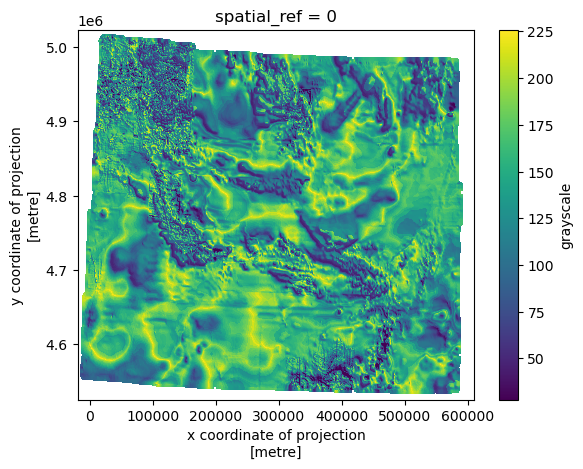

In [18]:
raster1_40m.grayscale.plot()

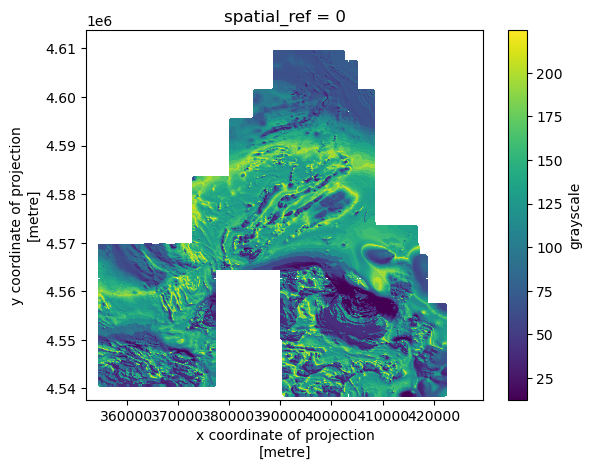

In [19]:
raster2_40m.grayscale.plot()

In [20]:
raster2_40m = raster2_40m.rename({'grayscale': 'grayscale_EarthMRI'})

### Let's merge em

In [21]:
raster1_40m.to_netcdf('raster1.nc')
raster2_40m.to_netcdf('raster2.nc')

In [22]:
ds1 = xr.open_dataset('raster1.nc')
print(f"ds1 resolution: {ds1.rio.resolution()}")
ds2 = xr.open_dataset('raster2.nc')
print(f"ds2 resolution: {ds2.rio.resolution()}")

ds1 resolution: (40.0, -40.0)
ds2 resolution: (40.0, -40.0)


In [23]:
def align_and_merge_datasets(ds1, ds2, decimal_places=8):
    """
    Align and merge two xarray datasets, putting ds2 onto ds1's dimensions.
    ds2 should be smaller and fit inside ds1's coordinate range.
    
    Parameters:
    -----------
    ds1, ds2 : xarray.Dataset
        The datasets to merge. ds1's dimensions will be preserved.
        ds2 should be smaller and fit within ds1's coordinate range.
    decimal_places : int, optional
        Number of decimal places to round coordinates to
    
    Returns:
    --------
    xarray.Dataset
        Merged dataset with ds1's coordinates
    """
    # Create copies to avoid modifying original datasets
    ds1 = ds1.copy()
    ds2 = ds2.copy()
    
    # Print coordinate ranges before alignment
    print("Coordinate ranges before alignment:")
    print(f"ds1 x: {ds1.x.min().values:.2f} to {ds1.x.max().values:.2f}")
    print(f"ds1 y: {ds1.y.min().values:.2f} to {ds1.y.max().values:.2f}")
    print(f"ds2 x: {ds2.x.min().values:.2f} to {ds2.x.max().values:.2f}")
    print(f"ds2 y: {ds2.y.min().values:.2f} to {ds2.y.max().values:.2f}")
    
    # Verify ds2 fits within ds1
    if (ds2.x.min() < ds1.x.min() or ds2.x.max() > ds1.x.max() or
        ds2.y.min() < ds1.y.min() or ds2.y.max() > ds1.y.max()):
        raise ValueError("ds2 coordinates must fit within ds1 coordinate range")
    
    # Round coordinates
    for coord in ['x', 'y']:
        if coord in ds1.coords and coord in ds2.coords:
            ds1 = ds1.assign_coords({coord: ds1[coord].round(decimal_places)})
            ds2 = ds2.assign_coords({coord: ds2[coord].round(decimal_places)})
    
    # Find the closest indices in ds1 for ds2's boundaries
    x_start_idx = np.abs(ds1.x - ds2.x.min()).argmin()
    x_end_idx = np.abs(ds1.x - ds2.x.max()).argmin()
    y_start_idx = np.abs(ds1.y - ds2.y.min()).argmin()
    y_end_idx = np.abs(ds1.y - ds2.y.max()).argmin()
    
    # Calculate coordinate shifts
    x_shift_start = float(ds1.x[x_start_idx] - ds2.x.min())
    x_shift_end = float(ds1.x[x_end_idx] - ds2.x.max())
    y_shift_start = float(ds1.y[y_start_idx] - ds2.y.min())
    y_shift_end = float(ds1.y[y_end_idx] - ds2.y.max())
    
    print("\nAlignment shifts required:")
    print(f"X shift at start: {x_shift_start:.8f}")
    print(f"X shift at end: {x_shift_end:.8f}")
    print(f"Y shift at start: {y_shift_start:.8f}")
    print(f"Y shift at end: {y_shift_end:.8f}")
    
    # Create a template dataset with ds1's coordinates
    ds2_aligned = ds2.reindex_like(
        ds1,
        method='nearest'
    )
    
    # Merge the datasets
    merged = xr.merge(
        [ds1, ds2_aligned],
        combine_attrs="override"
    )
    
    # Print final dimensions
    print("\nFinal dimensions:")
    print(f"Original ds1: {len(ds1.x)} x points, {len(ds1.y)} y points")
    print(f"Original ds2: {len(ds2.x)} x points, {len(ds2.y)} y points")
    print(f"Merged result: {len(merged.x)} x points, {len(merged.y)} y points")
    
    # Verify dimensions match ds1
    if len(merged.x) != len(ds1.x) or len(merged.y) != len(ds1.y):
        raise ValueError("Merged dataset dimensions do not match ds1 dimensions!")
    
    return merged

In [24]:
merged_ds = align_and_merge_datasets(ds1, ds2, decimal_places=6)

Coordinate ranges before alignment:
ds1 x: -19588.44 to 610491.56
ds1 y: 4525840.61 to 5022760.61
ds2 x: 352166.03 to 429646.03
ds2 y: 4537746.48 to 4613786.48

Alignment shifts required:
X shift at start: 5.52566500
X shift at end: 5.52566500
Y shift at start: 14.12783300
Y shift at end: 14.12783300

Final dimensions:
Original ds1: 15753 x points, 12424 y points
Original ds2: 1938 x points, 1902 y points
Merged result: 15753 x points, 12424 y points


In [25]:
merged_ds

<xarray.Dataset> Size: 3GB
Dimensions:             (y: 12424, x: 15753)
Coordinates:
  * x                   (x) float64 126kB -1.959e+04 -1.955e+04 ... 6.105e+05
  * y                   (y) float64 99kB 5.023e+06 5.023e+06 ... 4.526e+06
Data variables:
    spatial_ref         int64 8B 0
    grayscale           (y, x) float64 2GB ...
    grayscale_EarthMRI  (y, x) float64 2GB ...

In [26]:
# Configure compression
encoding = {var: {'compressor': zarr.Blosc(cname='lz4', clevel=7, shuffle=zarr.Blosc.SHUFFLE)}
           for var in merged_ds.data_vars}

merged_ds.load()

# Chunk in both dimensions
merged_ds = merged_ds.chunk({
    'x': 128,
    'y': 128  # Adding y dimension chunking
})

# Write with these optimized settings
merged_ds.to_zarr('merged.zarr', 
                 encoding=encoding,
                 consolidated=True,
                 mode='w')

/Users/tmartin/miniforge3/envs/py312/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 2.92 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [27]:
merged = xr.open_dataset('merged.zarr')

/Users/tmartin/miniforge3/envs/py312/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/Users/tmartin/miniforge3/envs/py312/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


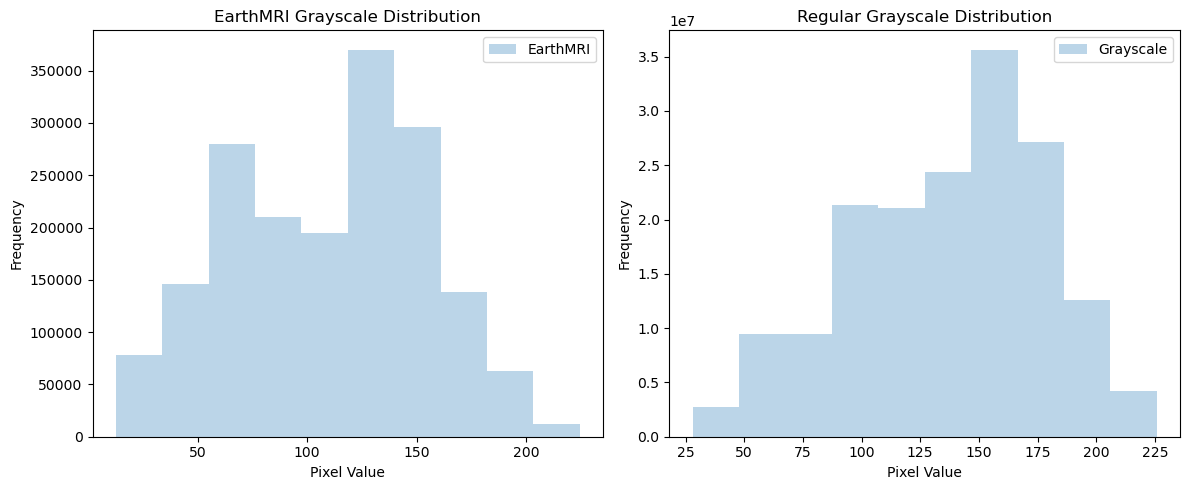

In [28]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot - EarthMRI histogram
ax1.hist(merged.grayscale_EarthMRI.values.ravel(), alpha=0.3, label='EarthMRI')
ax1.set_title('EarthMRI Grayscale Distribution')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')
ax1.legend()

# Second subplot - grayscale histogram
ax2.hist(merged.grayscale.values.ravel(), alpha=0.3, label='Grayscale')
ax2.set_title('Regular Grayscale Distribution')
ax2.set_xlabel('Pixel Value')
ax2.set_ylabel('Frequency')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [29]:
merged

<xarray.Dataset> Size: 3GB
Dimensions:             (y: 12424, x: 15753)
Coordinates:
  * x                   (x) float64 126kB -1.959e+04 -1.955e+04 ... 6.105e+05
  * y                   (y) float64 99kB 5.023e+06 5.023e+06 ... 4.526e+06
Data variables:
    grayscale           (y, x) float64 2GB nan nan nan nan ... nan nan nan nan
    grayscale_EarthMRI  (y, x) float64 2GB nan nan nan nan ... nan nan nan nan
    spatial_ref         int64 8B ...

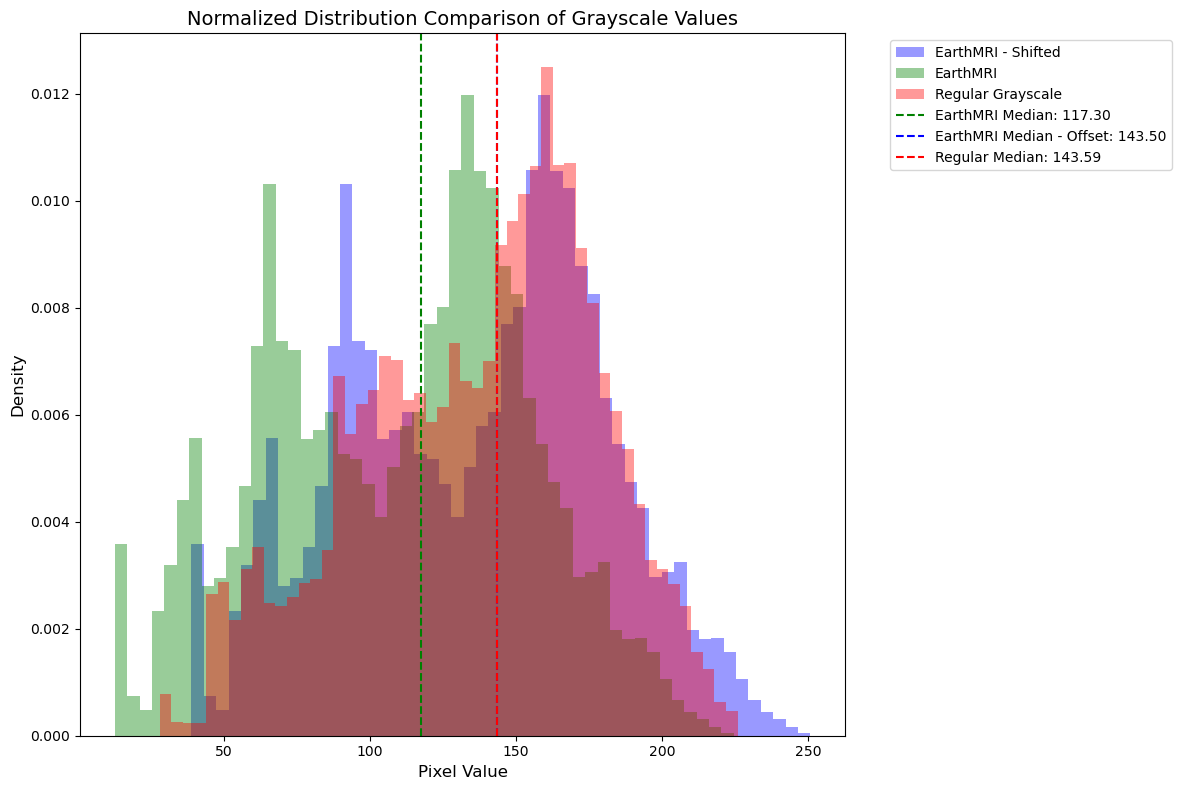

In [30]:
offset =  26.2

# Calculate medians
median_earthmri = np.nanmedian(merged.grayscale_EarthMRI.values.ravel())
median_regular = np.nanmedian(merged.grayscale.values.ravel())

# Create figure with larger size
plt.figure(figsize=(12, 8))

# Plot histograms with different colors and alpha values
plt.hist(offset+merged.grayscale_EarthMRI.values.ravel(), 
         density=True, 
         alpha=0.4, 
         color='blue',
         label='EarthMRI - Shifted', 
         bins=50)

plt.hist(merged.grayscale_EarthMRI.values.ravel(), 
         density=True, 
         alpha=0.4, 
         color='green',
         label='EarthMRI', 
         bins=50)

plt.hist(merged.grayscale.values.ravel(), 
         density=True, 
         alpha=0.4, 
         color='red',
         label='Regular Grayscale', 
         bins=50)

# Add vertical lines for medians with different colors
plt.axvline(x=median_earthmri, 
            color='green', 
            linestyle='--', 
            label=f'EarthMRI Median: {median_earthmri:.2f}')

plt.axvline(x=median_earthmri+offset, 
            color='blue', 
            linestyle='--', 
            label=f'EarthMRI Median - Offset: {offset+median_earthmri:.2f}')

plt.axvline(x=median_regular, 
            color='red', 
            linestyle='--', 
            label=f'Regular Median: {median_regular:.2f}')

# Customize the plot
plt.xlabel('Pixel Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Normalized Distribution Comparison of Grayscale Values', fontsize=14)

# Add legend with smaller font size and move it outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [31]:
array1 = merged_ds['grayscale'].values
array2 = merged_ds['grayscale_EarthMRI'].values

/Users/tmartin/miniforge3/envs/py312/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 1.46 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [32]:
# Method 1: Using stack
array_3d = np.stack([merged.grayscale.values, 
                     merged.grayscale_EarthMRI.values], 
                     axis=0)

array_3d.shape

(2, 12424, 15753)

In [33]:
def sample_squares(array3d, num_squares, square_size, layer1, layer2, nan_threshold=0.60):
    """
    Sample random squares from two specific layers of a 3D array,
    skipping squares that contain too many NaN values.
    
    Parameters:
    -----------
    array3d : numpy.ndarray
        Input 3D array with shape (depth, height, width)
    num_squares : int
        Number of squares to sample
    square_size : int
        Size of each square (square_size x square_size)
    layer1 : int
        First layer to sample from
    layer2 : int
        Second layer to sample from
    nan_threshold : float, optional
        Maximum allowed proportion of NaN values in a square (default: 0.6)
        Squares with a higher proportion of NaNs will be rejected
        
    Returns:
    --------
    tuple
        Two 3D numpy arrays, each with shape (num_valid_squares, square_size, square_size)
        Note: The number of returned squares might be less than num_squares if many contain NaNs
    """
    
    height, width = array3d.shape[1:]
    
    # Validate inputs
    if square_size > min(height, width):
        raise ValueError("Square size cannot be larger than array dimensions")
    
    if not 0 <= nan_threshold <= 1:
        raise ValueError("nan_threshold must be between 0 and 1")
    
    # Calculate valid ranges for random sampling
    max_y = height - square_size + 1
    max_x = width - square_size + 1
    
    # Calculate the maximum number of NaN values allowed per square
    total_pixels = square_size * square_size
    max_nans = int(total_pixels * nan_threshold)
    
    # Initialize lists to store valid samples
    valid_samples1 = []
    valid_samples2 = []
    
    # Counter for attempts to prevent infinite loops
    max_attempts = num_squares * 500
    attempts = 0
    
    while len(valid_samples1) < num_squares and attempts < max_attempts:
        y_start = np.random.randint(0, max_y)
        x_start = np.random.randint(0, max_x)
        
        # Extract squares from both layers
        square1 = array3d[layer1,
                         y_start:y_start + square_size,
                         x_start:x_start + square_size]
        square2 = array3d[layer2,
                         y_start:y_start + square_size,
                         x_start:x_start + square_size]
        
        # Count NaN values in each square
        nan_count1 = np.isnan(square1).sum()
        nan_count2 = np.isnan(square2).sum()
        
        # Check if either square has too many NaNs
        if (nan_count1 <= max_nans) and (nan_count2 <= max_nans):
            valid_samples1.append(square1)
            valid_samples2.append(square2)
        
        attempts += 1
    
    if len(valid_samples1) == 0:
        raise ValueError(f"Could not find any valid squares with less than {nan_threshold*100}% NaN values")
    
    if len(valid_samples1) < num_squares:
        print(f"Warning: Only found {len(valid_samples1)} valid squares out of {num_squares} requested")
    
    # Convert lists to numpy arrays
    samples1 = np.array(valid_samples1)
    samples2 = np.array(valid_samples2)
            
    return samples1, samples2

In [34]:
state_samples, earth_mri_samples = sample_squares(array_3d, 
                                      num_squares=25000,  # or however many squares you want
                                      square_size=64,  # or whatever size you want
                                      layer1 = 0,
                                      layer2 = 1)   

In [35]:
def interpolate_2d_nans(data):
    """
    Interpolate NaN values in each 2D slice of a 3D numpy array using nearest neighbor interpolation.
    Processes each (height, width) slice independently. Requires square spatial dimensions.
    
    Parameters:
    data: numpy.ndarray (frames, height, width) where height = width
    Returns:
    numpy.ndarray with NaN values interpolated within each 2D slice
    
    Raises:
    ValueError: If input shape is not (n, x, x) where x is equal height and width
    """
    # Validate input shape
    if len(data.shape) != 3:
        raise ValueError(f"Expected 3D array, got shape {data.shape}")
    
    n_frames, height, width = data.shape
    if height != width:
        raise ValueError(f"Spatial dimensions must be square, got height={height}, width={width}")
    
    print(f"Input - Shape: {data.shape}")
    print(f"Input - Square spatial dimension: {height}x{width}")
    
    result = data.copy()
    
    # Process each frame independently
    for frame in range(n_frames):
        slice_data = data[frame]
        nan_mask = np.isnan(slice_data)
        
        if not np.any(nan_mask):
            continue
            
        # Get 2D coordinates of valid points in this slice
        y_valid, x_valid = np.nonzero(~nan_mask)
        values = slice_data[~nan_mask]
        
        # Create and apply interpolator for this slice
        coords = np.column_stack((y_valid, x_valid))
        interpolator = interpolate.NearestNDInterpolator(coords, values)
        
        # Get coordinates of NaN points in this slice
        y_nan, x_nan = np.nonzero(nan_mask)
        nan_coords = np.column_stack((y_nan, x_nan))
        
        # Interpolate NaN values
        result[frame][nan_mask] = interpolator(nan_coords)
    
    print(f"Output - Contains NaNs: {np.any(np.isnan(result))}")
    print(f"Output - Number of NaNs: {np.sum(np.isnan(result))}")
    print(f"Output - Shape: {result.shape}")
    return result

In [36]:
state_samples_no_nan = interpolate_2d_nans(state_samples)

Input - Shape: (25000, 64, 64)
Input - Square spatial dimension: 64x64
Output - Contains NaNs: False
Output - Number of NaNs: 0
Output - Shape: (25000, 64, 64)


In [37]:
earth_mri_samples_no_nan = interpolate_2d_nans(earth_mri_samples)

Input - Shape: (25000, 64, 64)
Input - Square spatial dimension: 64x64
Output - Contains NaNs: False
Output - Number of NaNs: 0
Output - Shape: (25000, 64, 64)


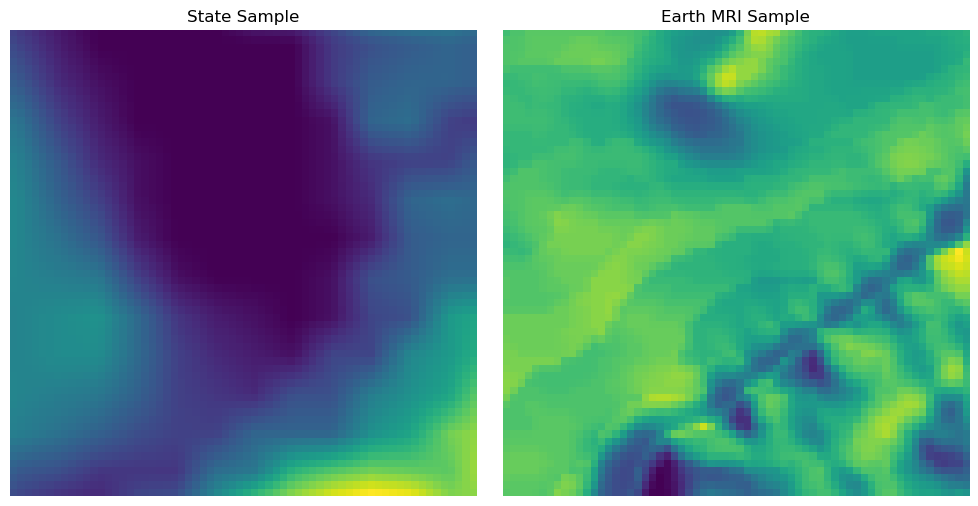

In [38]:
n_index = 500

# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot first image
ax1.imshow(state_samples_no_nan[n_index])
ax1.set_title('State Sample')
ax1.axis('off')  # Hide axes for cleaner look

# Plot second image
ax2.imshow(earth_mri_samples_no_nan[n_index])
ax2.set_title('Earth MRI Sample')
ax2.axis('off')  # Hide axes for cleaner look

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [39]:
def standardize_3d_array(array_3d, verbose=True):
    """
    Standardize a 3D numpy array as a single distribution.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        Input 3D array to be standardized
    verbose : bool, optional (default=True)
        If True, prints verification statistics
        
    Returns:
    --------
    array_3d_scaled : numpy.ndarray
        Standardized array with same shape as input
    scaler : sklearn.preprocessing.StandardScaler
        Fitted scaler object for potential reuse
    """
    # Keep original shape
    original_shape = array_3d.shape
    
    # Flatten array and reshape to 2D array of shape (-1, 1)
    array_flat = array_3d.ravel().reshape(-1, 1)
    
    # Fit and transform
    scaler = StandardScaler()
    array_scaled = scaler.fit_transform(array_flat)
    
    # Reshape back to 3D
    array_3d_scaled = array_scaled.reshape(original_shape)
    
    if verbose:
        print(f"Original array - Mean: {np.mean(array_3d):.8f}, Std: {np.std(array_3d):.8f}")
        print(f"Scaled array   - Mean: {np.mean(array_3d_scaled):.8f}, Std: {np.std(array_3d_scaled):.8f}")
        print(f"Shape: {array_3d_scaled.shape}")
    
    return array_3d_scaled, scaler

In [40]:
scaled_array1, scaler1 = standardize_3d_array(state_samples_no_nan)

# Second array
scaled_array2, scaler2 = standardize_3d_array(earth_mri_samples_no_nan)


Original array - Mean: 104.35984916, Std: 44.04836055
Scaled array   - Mean: 0.00000000, Std: 1.00000000
Shape: (25000, 64, 64)
Original array - Mean: 109.56377894, Std: 44.90587323
Scaled array   - Mean: 0.00000000, Std: 1.00000000
Shape: (25000, 64, 64)


In [41]:
def augment_with_rotations(data):
    """
    Augment image dataset by rotating each image by 90, 180, and 270 degrees.
    
    Parameters:
        data: numpy array of shape (n_samples, height, width)
    
    Returns:
        augmented_data: numpy array of shape (n_samples * 4, height, width)
    """
    # Get the original shape
    n_samples, height, width = data.shape
    print(f"Input shape: {data.shape}")
    
    # Validate input dimensions
    if len(data.shape) != 3:
        raise ValueError("Input data must be 3-dimensional (n_samples, height, width)")
    
    # Initialize array to hold original and rotated images
    augmented_data = np.zeros((n_samples * 4, height, width))
    
    # Fill in the augmented data
    for i in range(n_samples):
        # Original image
        augmented_data[i*4] = data[i]
        
        # 90 degree rotation
        augmented_data[i*4 + 1] = np.rot90(data[i])
        
        # 180 degree rotation
        augmented_data[i*4 + 2] = np.rot90(data[i], k=2)
        
        # 270 degree rotation
        augmented_data[i*4 + 3] = np.rot90(data[i], k=3)
        
        if i == 0:  # Print shapes for first sample only
            print(f"Sample {i} rotations shapes:")
            print(f"Original: {augmented_data[i*4].shape}")
            print(f"90°: {augmented_data[i*4 + 1].shape}")
            print(f"180°: {augmented_data[i*4 + 2].shape}")
            print(f"270°: {augmented_data[i*4 + 3].shape}")
    
    print(f"Output shape: {augmented_data.shape}")
    return augmented_data

In [42]:
augmented_array1 = augment_with_rotations(scaled_array1)

Input shape: (25000, 64, 64)
Sample 0 rotations shapes:
Original: (64, 64)
90°: (64, 64)
180°: (64, 64)
270°: (64, 64)
Output shape: (100000, 64, 64)


In [43]:
augmented_array2 = augment_with_rotations(scaled_array2)

Input shape: (25000, 64, 64)
Sample 0 rotations shapes:
Original: (64, 64)
90°: (64, 64)
180°: (64, 64)
270°: (64, 64)
Output shape: (100000, 64, 64)
